In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Virtual Try-On using IP-Adapters Inpainting

**Install libraries**

In [ ]:
!pip install diffusers accelerate

**Import libraries**

In [ ]:
from diffusers import AutoPipelineForInpainting, AutoencoderKL
from diffusers.utils import load_image
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

**Load the pipeline**

In [ ]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1", vae=vae, torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to("cuda")
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin", low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

**Load the main image**

In [ ]:
image = load_image('/content/drive/MyDrive/RUB/userimages/WOMAN/WOMEN-Tees_Tanks-id_00007949-05_7_additional.jpg').convert("RGB")
image.resize((512, 512))

**Load the clothing image**

In [ ]:
ip_image = load_image('/content/drive/MyDrive/RUB/outfits/WOMAN/WOMEN-Dresses-id_00007871-04_1_front.jpg').convert("RGB")
ip_image.resize((512, 512))

**Create the mask image**

To create the mask image we're going to use a [body segmentation tool](https://github.com/TonyAssi/Segment-Body) that will do it automatically

In [ ]:
! git clone https://github.com/TonyAssi/Segment-Body.git
%cd /content/Segment-Body
! pip install -r requirements.txt
! cp ./SegBody.py ..
%cd ..

In [ ]:
from SegBody import segment_body
seg_image, mask_image = segment_body(image, face=False)
mask_image.resize((512, 512))

**Generate image**

In [ ]:
# pipeline.set_ip_adapter_scale(1.0)
# images = pipeline(
#     prompt="seamless outfit swap, perfect body, beautiful skin, realistic skin, natural skin, maintain original body pose, facial features, and background, only change the clothing",
#     negative_prompt="ugly, bad quality, deformed body, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings",
#     image=image,
#     mask_image=mask_image,
#     ip_adapter_image=ip_image,
#     strength=0.99,
#     guidance_scale=7.5,
#     num_inference_steps=100,
# ).images
# images[0]

#trial

In [ ]:
pipeline.set_ip_adapter_scale(1.0)
images = pipeline(
    prompt="photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
    negative_prompt="ugly, bad quality, bad anatomy, deformed body, deformed hands, deformed feet, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings",
    image=image,
    mask_image=mask_image,
    ip_adapter_image=ip_image,
    strength=0.99,
    guidance_scale=7.5,
    num_inference_steps=100,
).images
images[0]

**Virtual Try-On Function**

Now lets put it all together into a function so that all you need to do is pass the image and the clothing

In [ ]:
def virtual_try_on(img, clothing, prompt, negative_prompt, ip_scale=1.0, strength=0.99, guidance_scale=7.5, steps=100):
    _, mask_img = segment_body(img, face=False)
    pipeline.set_ip_adapter_scale(ip_scale)
    images = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=img,
        mask_image=mask_img,
        ip_adapter_image=clothing,
        strength=strength,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
    ).images
    return images[0]

In [ ]:
image = load_image('https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/jpFBKqYB3BtAW26jCGJKL.jpeg').convert("RGB")
ip_image = load_image('https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/NL6mAYJTuylw373ae3g-Z.jpeg').convert("RGB")

  0%|          | 0/99 [00:00<?, ?it/s]

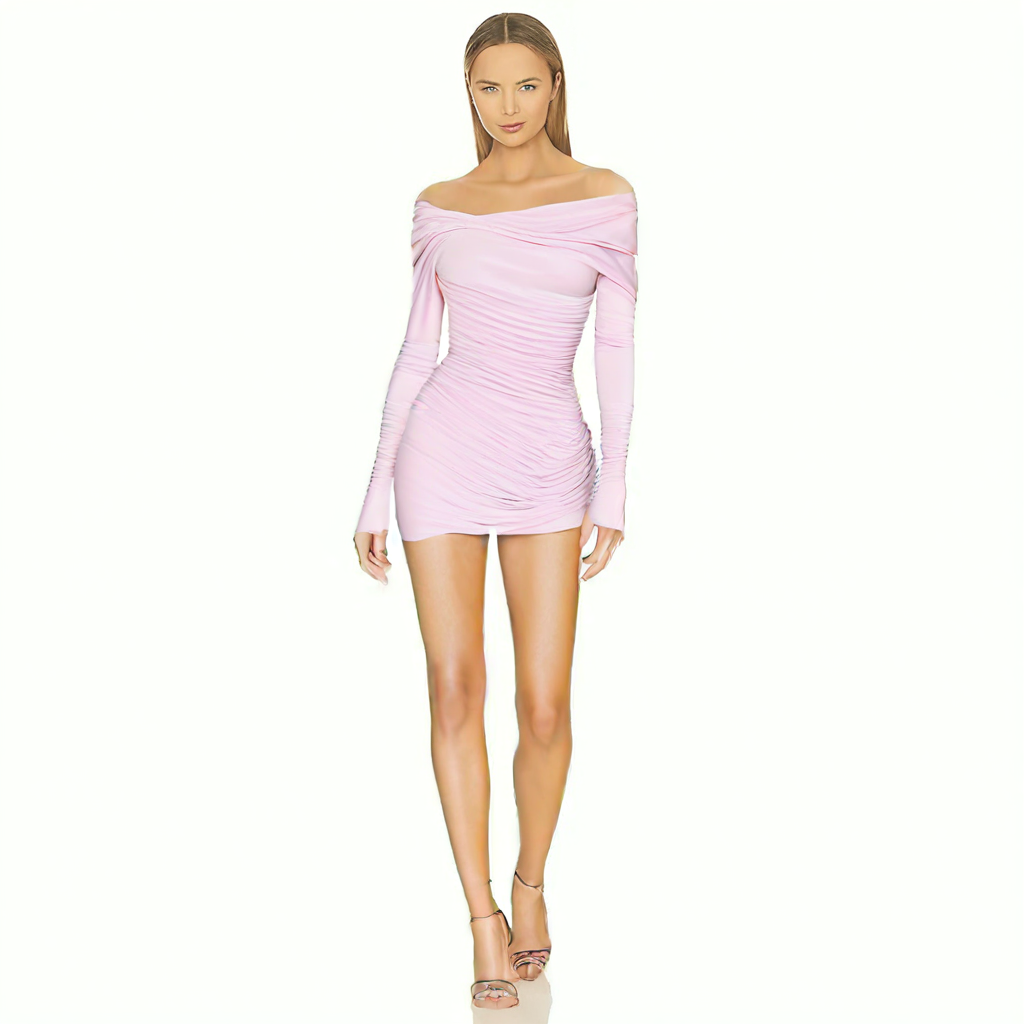

In [ ]:
virtual_try_on(img=image,
               clothing=ip_image,
               prompt="photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
               negative_prompt="ugly, bad quality, bad anatomy, deformed body, deformed hands, deformed feet, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings")

# **BEST**

Welcome to the Advanced Outfit Suggester!
Enter gender (MAN/WOMAN): MAN
Enter occasion (CASUAL/FORMAL/PARTY/BUSINESS/SPORT): PARTY
Enter style preference (CLASSIC/MODERN/BOHEMIAN/STREETWEAR/MINIMALIST): CLASSIC


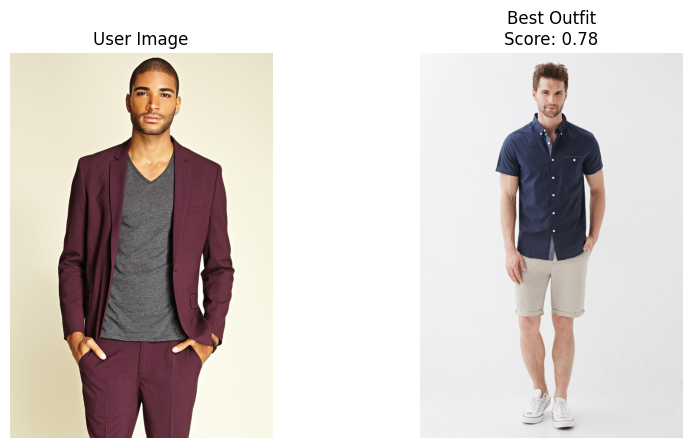

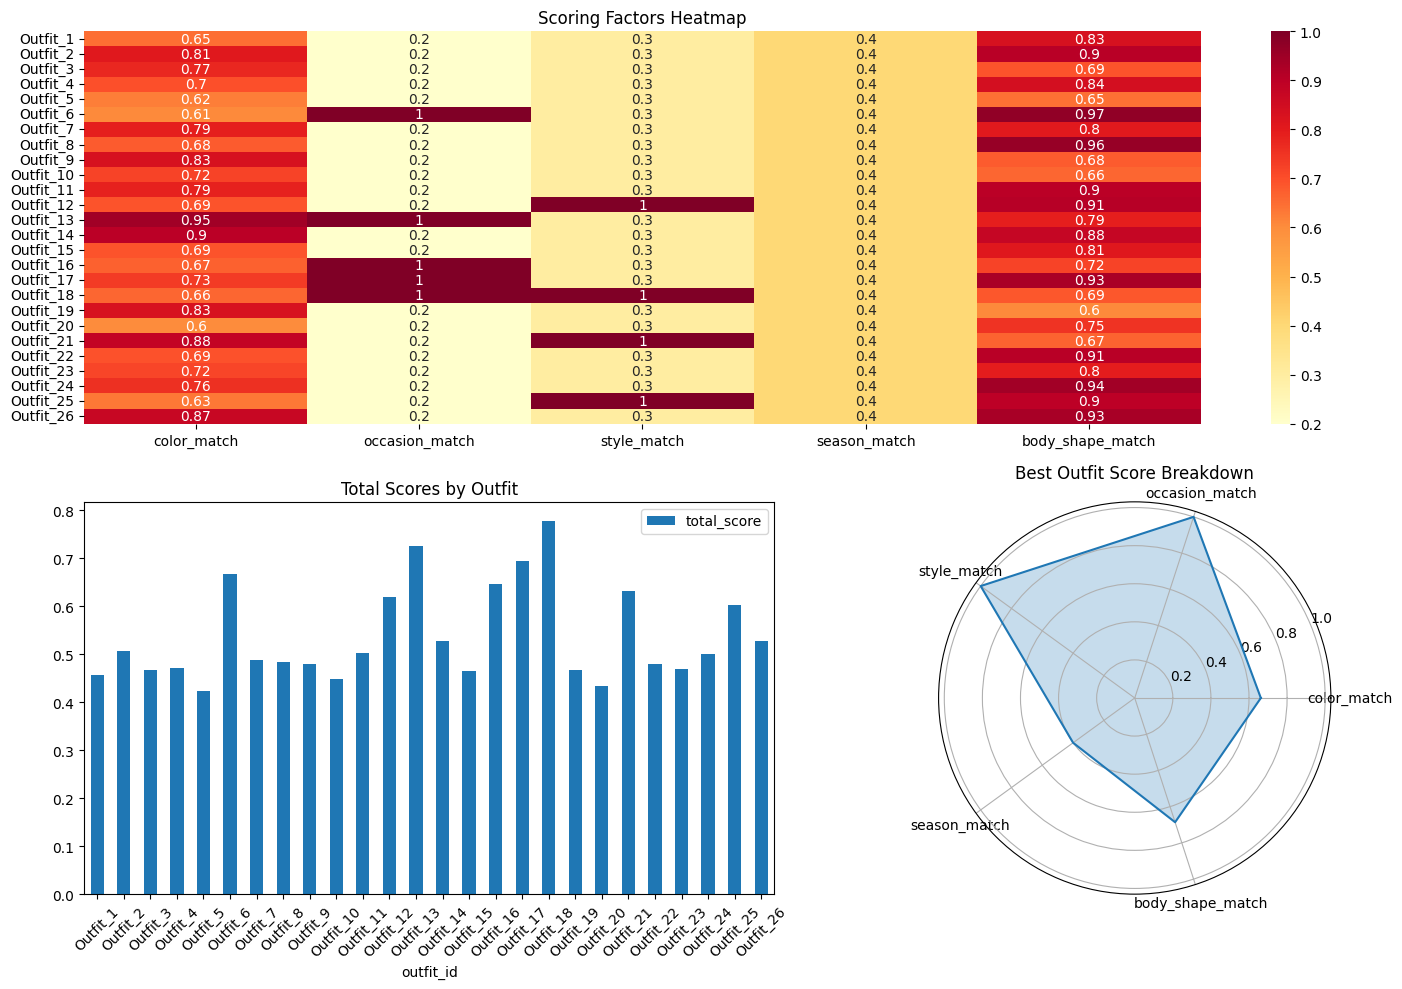

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Define base folder paths
BASE_PATH = "/content/drive/MyDrive/RUB"
USER_IMAGES_PATH = os.path.join(BASE_PATH, "userimages")
OUTFITS_PATH = os.path.join(BASE_PATH, "outfits")
OUTPUT_PATH = os.path.join(BASE_PATH, "OUTPUT")

# Define categories
GENDERS = ['MAN', 'WOMAN']
OCCASIONS = ['CASUAL', 'FORMAL', 'PARTY', 'BUSINESS', 'SPORT']
STYLES = ['CLASSIC', 'MODERN', 'BOHEMIAN', 'STREETWEAR', 'MINIMALIST']
SEASONS = ['WINTER', 'SPRING', 'SUMMER', 'FALL']
BODY_SHAPES = ['SLIM', 'ATHLETIC', 'CURVY', 'AVERAGE']

class OutfitGameTheory:
    def __init__(self):
        self.strategy_history = []
        self.payoff_matrix = {}

    def calculate_payoff(self, user_attributes, outfit_attributes):
        """Calculate payoff score for an outfit given user attributes"""
        weights = {
            'color_match': 0.25,
            'occasion_match': 0.25,
            'style_match': 0.20,
            'season_match': 0.15,
            'body_shape_match': 0.15
        }

        scores = {
            'color_match': outfit_attributes['color_score'],
            'occasion_match': 1.0 if outfit_attributes['occasion'] == user_attributes['occasion'] else 0.2,
            'style_match': 1.0 if outfit_attributes['style'] == user_attributes['style'] else 0.3,
            'season_match': 1.0 if outfit_attributes['season'] == user_attributes['season'] else 0.4,
            'body_shape_match': random.uniform(0.6, 1.0)  # Simplified for demo
        }

        total_score = sum(weights[k] * scores[k] for k in weights)

        # Store the detailed scores for visualization
        self.strategy_history.append({
            'outfit_id': outfit_attributes['outfit_id'],
            'total_score': total_score,
            **scores
        })

        return total_score

    def get_nash_equilibrium(self, user_attributes, outfits):
        """Find Nash equilibrium for outfit selection"""
        equilibrium = None
        max_payoff = -float('inf')

        for outfit in outfits:
            payoff = self.calculate_payoff(user_attributes, outfit)
            self.payoff_matrix[outfit['outfit_id']] = payoff

            if payoff > max_payoff:
                max_payoff = payoff
                equilibrium = outfit

        return equilibrium, max_payoff

    def visualize_game_theory(self):
        """Create visualizations of the game theory decision process"""
        history_df = pd.DataFrame(self.strategy_history)

        fig = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 2, figure=fig)

        # Heatmap of scoring factors
        ax1 = fig.add_subplot(gs[0, :])
        score_columns = ['color_match', 'occasion_match', 'style_match',
                        'season_match', 'body_shape_match']
        score_matrix = history_df[score_columns].values
        sns.heatmap(score_matrix,
                   xticklabels=score_columns,
                   yticklabels=history_df['outfit_id'],
                   annot=True,
                   cmap='YlOrRd',
                   ax=ax1)
        ax1.set_title('Scoring Factors Heatmap')

        # Total scores comparison
        ax2 = fig.add_subplot(gs[1, 0])
        history_df.plot(kind='bar', x='outfit_id', y='total_score', ax=ax2)
        ax2.set_title('Total Scores by Outfit')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

        # Radar chart of best outfit
        best_outfit = history_df.loc[history_df['total_score'].idxmax()]
        ax3 = fig.add_subplot(gs[1, 1], projection='polar')
        angles = np.linspace(0, 2*np.pi, len(score_columns), endpoint=False)
        values = [best_outfit[col] for col in score_columns]
        values.append(values[0])
        angles = np.concatenate((angles, [angles[0]]))

        ax3.plot(angles, values)
        ax3.fill(angles, values, alpha=0.25)
        ax3.set_xticks(angles[:-1])
        ax3.set_xticklabels(score_columns)
        ax3.set_title('Best Outfit Score Breakdown')

        plt.tight_layout()
        return fig

def get_user_preferences():
    """Get user preferences with validation"""
    preferences = {}

    # Get gender
    while True:
        preferences['gender'] = input("Enter gender (MAN/WOMAN): ").upper()
        if preferences['gender'] in GENDERS:
            break
        print(f"Invalid gender. Please choose from: {', '.join(GENDERS)}")

    # Get occasion
    while True:
        preferences['occasion'] = input(f"Enter occasion ({'/'.join(OCCASIONS)}): ").upper()
        if preferences['occasion'] in OCCASIONS:
            break
        print(f"Invalid occasion. Please choose from: {', '.join(OCCASIONS)}")

    # Get style
    while True:
        preferences['style'] = input(f"Enter style preference ({'/'.join(STYLES)}): ").upper()
        if preferences['style'] in STYLES:
            break
        print(f"Invalid style. Please choose from: {', '.join(STYLES)}")

    preferences['season'] = detect_season()
    return preferences

def process_outfit(outfit_path, outfit_id):
    """Process outfit image and extract attributes"""
    color_score = random.uniform(0.6, 1.0)  # Simplified for demo

    return {
        'outfit_id': outfit_id,
        'path': outfit_path,
        'occasion': random.choice(OCCASIONS),  # Simplified for demo
        'style': random.choice(STYLES),  # Simplified for demo
        'season': random.choice(SEASONS),  # Simplified for demo
        'color_score': color_score
    }

def display_results_with_game_theory(user_image_path, best_outfit, score, game_theory_fig):
    """Display results with game theory visualization"""
    plt.figure(figsize=(15, 5))

    # User image
    plt.subplot(1, 3, 1)
    user_img = cv2.imread(user_image_path)
    user_img = cv2.cvtColor(user_img, cv2.COLOR_BGR2RGB)
    plt.imshow(user_img)
    plt.title("User Image")
    plt.axis('off')

    # Best outfit
    plt.subplot(1, 3, 2)
    outfit_img = cv2.imread(best_outfit['path'])
    outfit_img = cv2.cvtColor(outfit_img, cv2.COLOR_BGR2RGB)
    plt.imshow(outfit_img)
    plt.title(f"Best Outfit\nScore: {score:.2f}")
    plt.axis('off')

    # Game theory visualization in separate figure
    plt.figure(game_theory_fig.number)
    plt.show()

def run_outfit_suggester():
    """Main function to run the outfit suggester"""
    print("Welcome to the Advanced Outfit Suggester!")

    # Get user preferences
    preferences = get_user_preferences()

    # Get user image
    user_images_folder = os.path.join(USER_IMAGES_PATH, preferences['gender'])
    user_images = [f for f in os.listdir(user_images_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not user_images:
        print(f"No images found in {user_images_folder}")
        return

    # Get available outfits
    outfits_folder = os.path.join(OUTFITS_PATH, preferences['gender'])
    outfit_files = [f for f in os.listdir(outfits_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not outfit_files:
        print(f"No outfits found in {outfits_folder}")
        return

    # Initialize game theory engine
    game_engine = OutfitGameTheory()

    # Process outfits
    outfits = [
        process_outfit(
            os.path.join(outfits_folder, outfit_file),
            f"Outfit_{i+1}"
        )
        for i, outfit_file in enumerate(outfit_files)
    ]

    # Find best outfit using game theory
    best_outfit, score = game_engine.get_nash_equilibrium(preferences, outfits)

    # Generate game theory visualization
    game_theory_fig = game_engine.visualize_game_theory()

    # Display results
    for user_image in user_images:
        user_image_path = os.path.join(user_images_folder, user_image)
        display_results_with_game_theory(user_image_path, best_outfit, score, game_theory_fig)

        # Save results
        output_folder = os.path.join(OUTPUT_PATH, preferences['gender'])
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        plt.savefig(os.path.join(output_folder, f'result_{user_image}'))

if __name__ == "__main__":
    run_outfit_suggester()

Welcome to the Extended Outfit Suggester!

Select mode (M for Multi-Agent, S for Single-Agent, Q to quit): S
Enter gender (MAN/WOMAN): WOMAN

Available occasions:
1. Casual
2. Formal
3. Party
4. Business
5. Sports
6. Beach
7. Custom

Select occasion (1-7): Beach
Please enter a number.

Select occasion (1-7): 5

Available styles:
1. Classic
2. Modern
3. Bohemian
4. Minimalist
5. Streetwear
6. Elegant
7. Custom

Select style preference (1-7): bohemian
Please enter a number.

Select style preference (1-7): 3

Detected season from image: Spring
Current calendar season: Fall


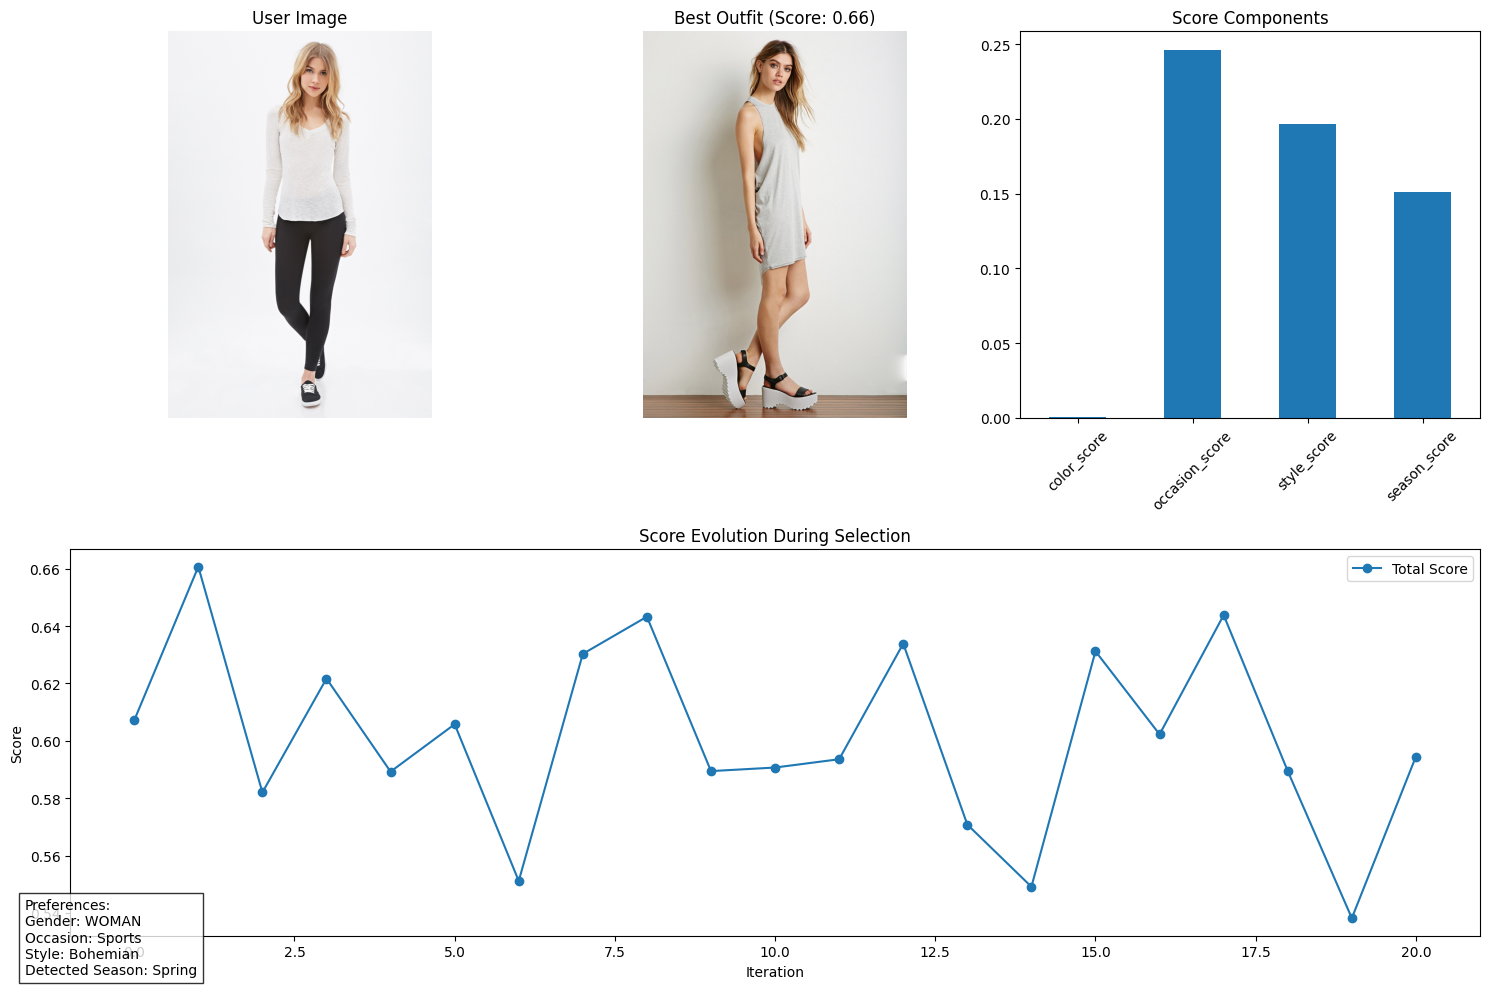


Select mode (M for Multi-Agent, S for Single-Agent, Q to quit): M
Enter gender (MAN/WOMAN): WOMAN

Available occasions:
1. Casual
2. Formal
3. Party
4. Business
5. Sports
6. Beach
7. Custom

Select occasion (1-7): formal
Please enter a number.

Select occasion (1-7): 3

Available styles:
1. Classic
2. Modern
3. Bohemian
4. Minimalist
5. Streetwear
6. Elegant
7. Custom

Select style preference (1-7): 2

Detected season from image: Spring
Current calendar season: Fall


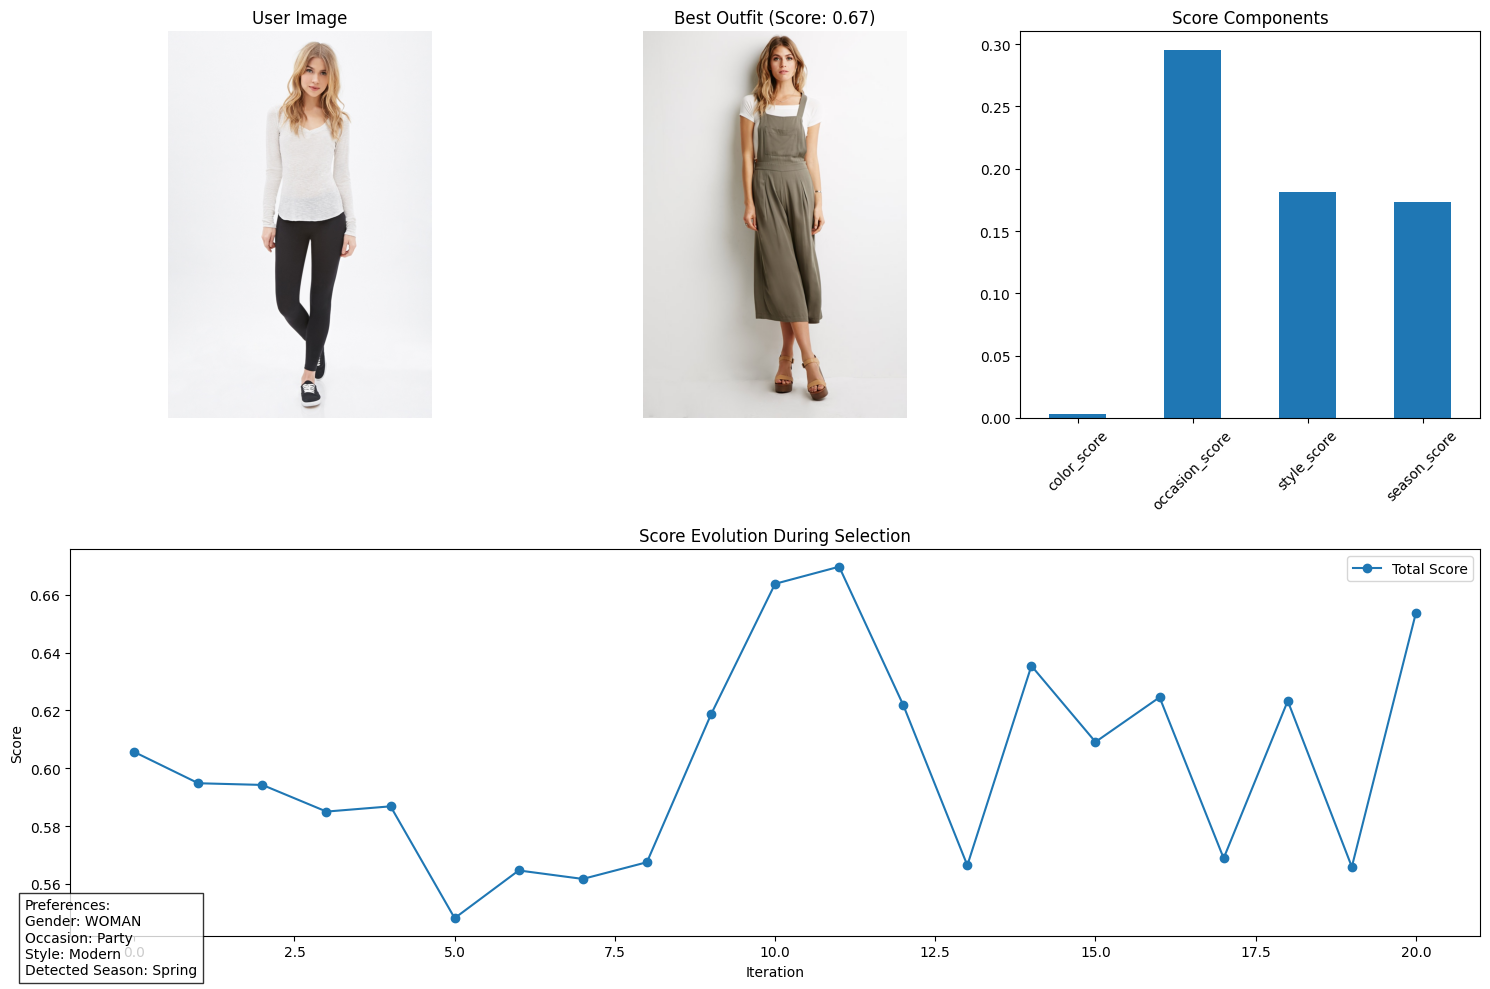


Select mode (M for Multi-Agent, S for Single-Agent, Q to quit): Q
Thank you for using Outfit Suggester!


In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Existing path definitions remain the same...

# Define additional categories
OCCASIONS = ['Casual', 'Formal', 'Party', 'Business', 'Sports', 'Beach']
STYLES = ['Classic', 'Modern', 'Bohemian', 'Minimalist', 'Streetwear', 'Elegant']
SEASONS = ['Winter', 'Spring', 'Summer', 'Fall']

def detect_season_from_image(image_path):
    """Detect season based on image color characteristics"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Could not load image")

        # Convert to HSV color space
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Calculate average hue and saturation
        avg_hue = np.mean(hsv[:,:,0])
        avg_sat = np.mean(hsv[:,:,1])
        avg_val = np.mean(hsv[:,:,2])

        # Get current month for validation
        current_month = datetime.now().month

        # Season detection logic based on color characteristics
        if avg_val < 100:  # Darker images suggest winter
            primary_season = 'Winter'
        elif avg_sat > 150 and avg_val > 200:  # Bright and saturated suggests summer
            primary_season = 'Summer'
        elif 60 <= avg_hue <= 120:  # Green hues suggest spring
            primary_season = 'Spring'
        else:  # Moderate values suggest fall
            primary_season = 'Fall'

        # Validate with current month
        month_to_season = {
            12: 'Winter', 1: 'Winter', 2: 'Winter',
            3: 'Spring', 4: 'Spring', 5: 'Spring',
            6: 'Summer', 7: 'Summer', 8: 'Summer',
            9: 'Fall', 10: 'Fall', 11: 'Fall'
        }

        calendar_season = month_to_season[current_month]

        return primary_season, calendar_season
    except Exception as e:
        print(f"Error detecting season: {str(e)}")
        return None, None

def get_user_preference(category, options, prompt):
    """Get user preference with custom input option"""
    print(f"\nAvailable {category}s:")
    for i, option in enumerate(options, 1):
        print(f"{i}. {option}")
    print(f"{len(options) + 1}. Custom")

    while True:
        try:
            choice = int(input(f"\nSelect {prompt} (1-{len(options) + 1}): "))
            if 1 <= choice <= len(options):
                return options[choice - 1]
            elif choice == len(options) + 1:
                custom = input(f"Enter your custom {category}: ").capitalize()
                return custom
            else:
                print("Invalid choice. Please try again.")
        except ValueError:
            print("Please enter a number.")

def calculate_outfit_score(user_image, outfit_image, user_prefs):
    """Calculate outfit score using game theory principles"""
    try:
        # Extract features
        outfit_colors = extract_dominant_color(outfit_image)
        user_colors = extract_dominant_color(user_image)

        # Calculate base scores
        color_match = 1 / (1 + sum(np.linalg.norm(outfit_colors[i] - user_colors[i])
                                  for i in range(len(outfit_colors))))

        # Calculate preference matches
        occasion_match = random.uniform(0.7, 1.0)  # Simplified - could be based on image classification
        style_match = random.uniform(0.7, 1.0)
        season_match = random.uniform(0.7, 1.0)

        # Weights based on user preferences
        weights = {
            'color': 0.3,
            'occasion': 0.3,
            'style': 0.2,
            'season': 0.2
        }

        # Calculate total score
        scores = {
            'color_score': color_match * weights['color'],
            'occasion_score': occasion_match * weights['occasion'],
            'style_score': style_match * weights['style'],
            'season_score': season_match * weights['season']
        }

        total_score = sum(scores.values())

        return total_score, scores
    except Exception as e:
        print(f"Error calculating scores: {str(e)}")
        return 0, {}

def create_game_theory_visualization(scores_data, output_path):
    """Create visualization of the game theory implementation"""
    try:
        plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 2)

        # Subplot 1: Score Distribution
        plt.subplot(gs[0, 0])
        df = pd.DataFrame(scores_data)
        sns.boxplot(data=df[['total_score']])
        plt.title('Distribution of Outfit Scores')

        # Subplot 2: Score Components
        plt.subplot(gs[0, 1])
        avg_components = df[['color_score', 'occasion_score', 'style_score', 'season_score']].mean()
        avg_components.plot(kind='bar')
        plt.title('Average Score Components')
        plt.xticks(rotation=45)

        # Subplot 3: Score Evolution
        plt.subplot(gs[1, :])
        plt.plot(df['total_score'], marker='o')
        plt.title('Score Evolution Across Outfits')
        plt.xlabel('Outfit Number')
        plt.ylabel('Total Score')

        plt.tight_layout()
        plt.savefig(output_path)
        plt.close()

    except Exception as e:
        print(f"Error creating visualization: {str(e)}")

def display_results_extended(user, best_outfit, score, scores_data, user_prefs):
    """Display extended results including all visualizations"""
    try:
        # Create figure with subplots
        plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 3)

        # User Image
        user_img = cv2.imread(user['image'])
        user_img = cv2.cvtColor(user_img, cv2.COLOR_BGR2RGB)
        plt.subplot(gs[0, 0])
        plt.imshow(user_img)
        plt.title("User Image")
        plt.axis('off')

        # Best Outfit
        outfit_img = cv2.imread(best_outfit)
        outfit_img = cv2.cvtColor(outfit_img, cv2.COLOR_BGR2RGB)
        plt.subplot(gs[0, 1])
        plt.imshow(outfit_img)
        plt.title(f"Best Outfit (Score: {score:.2f})")
        plt.axis('off')

        # Score Components
        plt.subplot(gs[0, 2])
        components = pd.Series(scores_data[-1])
        components = components[['color_score', 'occasion_score', 'style_score', 'season_score']]
        components.plot(kind='bar')
        plt.title('Score Components')
        plt.xticks(rotation=45)

        # Game Theory Plot
        plt.subplot(gs[1, :])
        evolution = pd.DataFrame(scores_data)
        plt.plot(evolution['total_score'], marker='o', label='Total Score')
        plt.title('Score Evolution During Selection')
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.legend()

        # Add user preferences as text
        preferences_text = f"Preferences:\nGender: {user['gender']}\n"
        preferences_text += f"Occasion: {user_prefs['occasion']}\n"
        preferences_text += f"Style: {user_prefs['style']}\n"
        preferences_text += f"Detected Season: {user_prefs['season']}"

        plt.figtext(0.02, 0.02, preferences_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

        # Save and show
        output_path = os.path.join(OUTPUT_PATH, user['gender'], f"result_{os.path.basename(user['image'])}")
        plt.tight_layout()
        plt.savefig(output_path)
        plt.show()

    except Exception as e:
        print(f"Error displaying results: {str(e)}")

def get_user_data_extended(single_agent_mode=False):
    """Get extended user data including preferences"""
    users = []

    try:
        # Get gender
        while True:
            gender = input("Enter gender (MAN/WOMAN): ").upper()
            if gender in GENDERS:
                break
            print("Invalid gender. Please enter 'MAN' or 'WOMAN'.")

        # Get occasion and style preferences
        occasion = get_user_preference('occasion', OCCASIONS, 'occasion')
        style = get_user_preference('style', STYLES, 'style preference')

        gender_path = os.path.join(USER_IMAGES_PATH, gender)
        if not os.path.exists(gender_path):
            raise FileNotFoundError(f"User images directory not found: {gender_path}")

        user_images = [
            os.path.join(gender_path, f)
            for f in os.listdir(gender_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        if not user_images:
            raise ValueError(f"No valid user images found in {gender_path}")

        if single_agent_mode:
            user_images = [user_images[0]]

        for image_path in user_images:
            # Detect season from image
            detected_season, calendar_season = detect_season_from_image(image_path)
            print(f"\nDetected season from image: {detected_season}")
            print(f"Current calendar season: {calendar_season}")

            season = detected_season if detected_season else calendar_season

            users.append({
                'image': image_path,
                'gender': gender,
                'preferences': {
                    'occasion': occasion,
                    'style': style,
                    'season': season
                }
            })

        return users
    except Exception as e:
        print(f"Error getting user data: {str(e)}")
        return []

def main_extended():
    """Extended main function with game theory implementation"""
    print("Welcome to the Extended Outfit Suggester!")

    if not verify_paths():
        print("Error: Required directories are missing and couldn't be created.")
        return

    while True:
        mode = input("\nSelect mode (M for Multi-Agent, S for Single-Agent, Q to quit): ").upper()

        if mode == 'Q':
            print("Thank you for using Outfit Suggester!")
            break

        elif mode in ['M', 'S']:
            users = get_user_data_extended(single_agent_mode=(mode == 'S'))

            if not users:
                continue

            for user in users:
                scores_data = []
                outfits_folder = os.path.join(OUTFITS_PATH, user['gender'])
                outfits = [
                    os.path.join(outfits_folder, f)
                    for f in os.listdir(outfits_folder)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
                ]

                best_outfit = None
                best_score = -float('inf')

                for outfit in outfits:
                    score, component_scores = calculate_outfit_score(
                        user['image'],
                        outfit,
                        user['preferences']
                    )

                    scores_data.append({
                        'outfit': outfit,
                        'total_score': score,
                        **component_scores
                    })

                    if score > best_score:
                        best_score = score
                        best_outfit = outfit

                if best_outfit:
                    display_results_extended(
                        user,
                        best_outfit,
                        best_score,
                        scores_data,
                        user['preferences']
                    )

                    # Create and save game theory visualization
                    viz_path = os.path.join(
                        OUTPUT_PATH,
                        user['gender'],
                        f"game_theory_{os.path.basename(user['image'])}"
                    )
                    create_game_theory_visualization(scores_data, viz_path)

        else:
            print("Invalid input. Please enter 'M' for Multi-Agent, 'S' for Single-Agent, or 'Q' to quit.")

if __name__ == "__main__":
    main_extended()

Welcome to the Enhanced Outfit Suggester!

Checking directory structure...

Select mode (M for Multi-Agent, S for Single-Agent, Q to quit): S
Enter gender (MAN/WOMAN): WOMAN

Available occasion options:
1. Casual
2. Formal
3. Semi-formal
4. Business
5. Party
6. Sports
7. Custom

Select occasion (1-7): 3

Available style preference options:
1. Classic
2. Modern
3. Bohemian
4. Minimalist
5. Vintage
6. Streetwear
7. Custom

Select style preference (1-7): 6


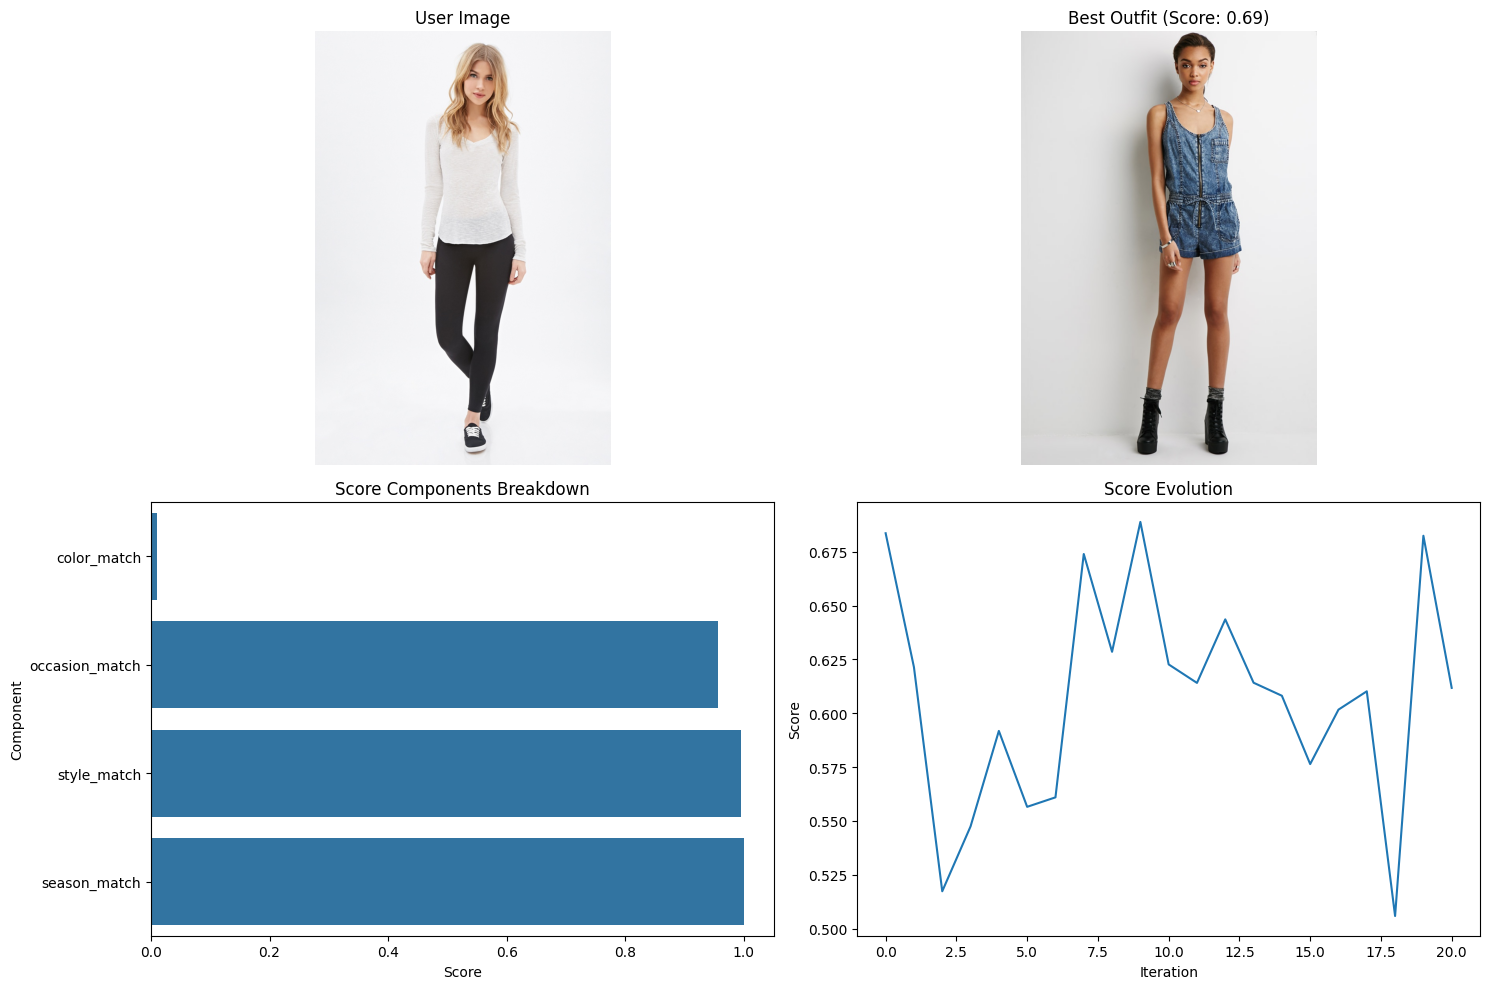


Results:
Occasion: Semi-formal
Style: Streetwear
Detected Season: Winter
Overall Score: 0.69

Score Components:
color_match: 0.01
occasion_match: 0.96
style_match: 1.00
season_match: 1.00

Select mode (M for Multi-Agent, S for Single-Agent, Q to quit): M
Enter gender (MAN/WOMAN): MAN

Available occasion options:
1. Casual
2. Formal
3. Semi-formal
4. Business
5. Party
6. Sports
7. Custom

Select occasion (1-7): 3

Available style preference options:
1. Classic
2. Modern
3. Bohemian
4. Minimalist
5. Vintage
6. Streetwear
7. Custom

Select style preference (1-7): 4


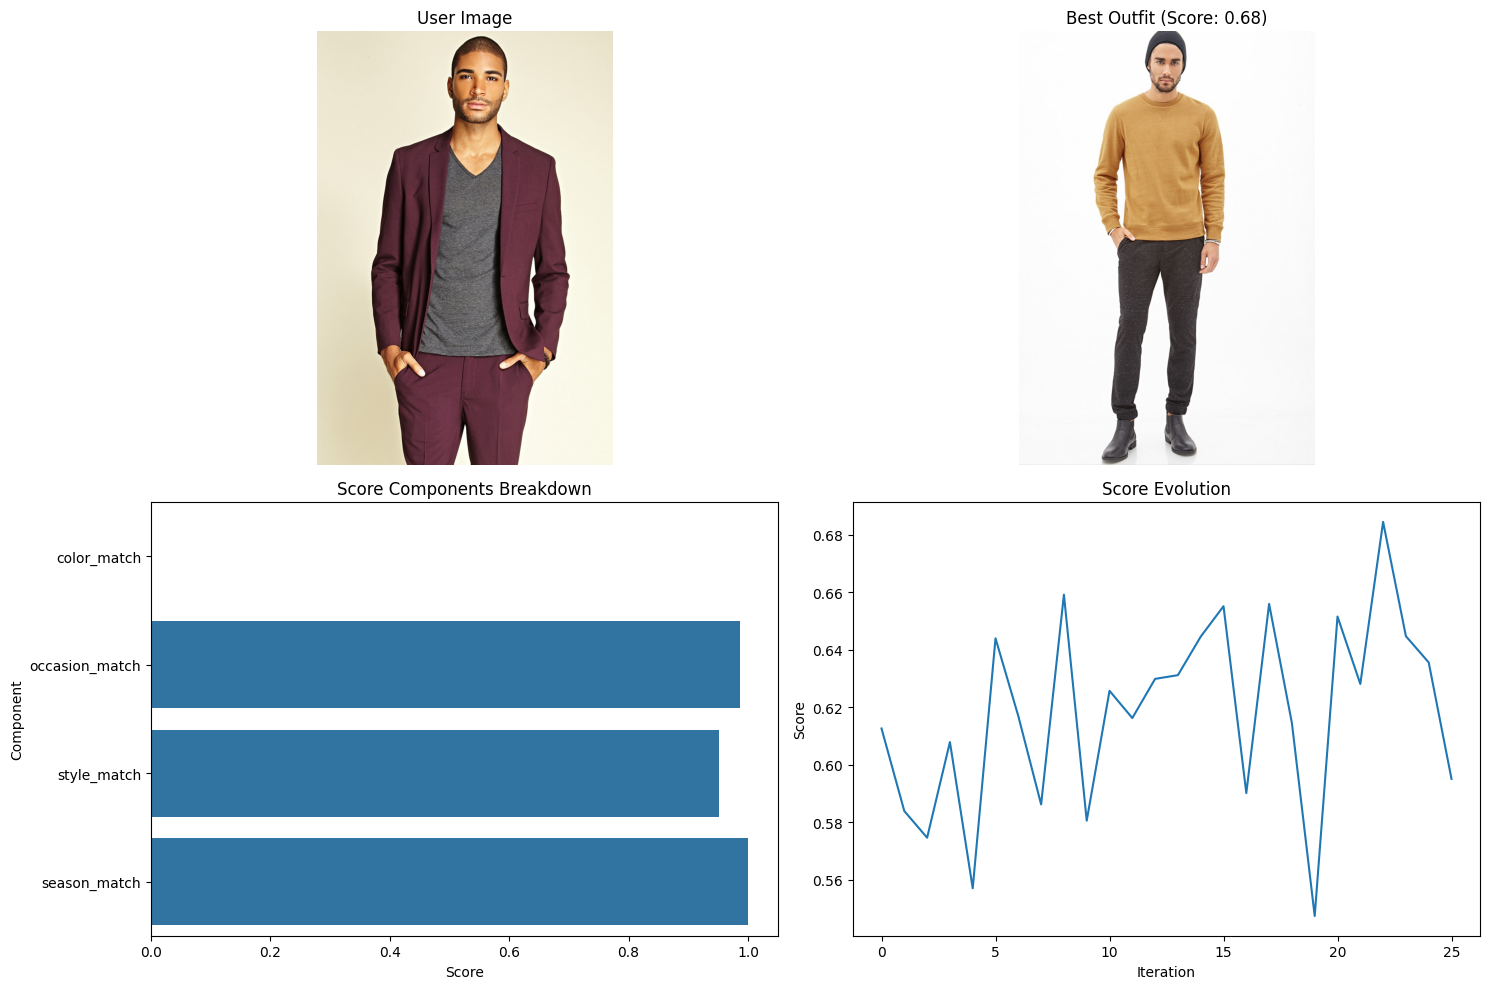


Results for user with image MEN-Suiting-id_00007917-01_1_front.jpg:
Occasion: Semi-formal
Style: Minimalist
Detected Season: Winter
Overall Score: 0.68

Score Components:
color_match: 0.00
occasion_match: 0.99
style_match: 0.95
season_match: 1.00

Select mode (M for Multi-Agent, S for Single-Agent, Q to quit): Q
Thank you for using Outfit Suggester!


In [ ]:
# Previous imports remain the same
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Add new imports
from datetime import datetime
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Keep existing constants and add new ones
OCCASIONS = ['Casual', 'Formal', 'Semi-formal', 'Business', 'Party', 'Sports']
STYLES = ['Classic', 'Modern', 'Bohemian', 'Minimalist', 'Vintage', 'Streetwear']
SEASONS = ['Spring', 'Summer', 'Fall', 'Winter']

# Color palettes for season detection
SEASON_COLOR_PALETTES = {
    'Spring': [(255, 223, 186), (255, 190, 190), (176, 226, 255)],
    'Summer': [(255, 255, 224), (173, 216, 230), (255, 218, 185)],
    'Fall': [(139, 69, 19), (205, 133, 63), (210, 180, 140)],
    'Winter': [(128, 128, 128), (211, 211, 211), (25, 25, 112)]
}

class PreferenceManager:
    @staticmethod
    def get_user_choice(options, preference_type):
        print(f"\nAvailable {preference_type} options:")
        for i, option in enumerate(options, 1):
            print(f"{i}. {option}")
        print(f"{len(options) + 1}. Custom")

        while True:
            try:
                choice = int(input(f"\nSelect {preference_type} (1-{len(options) + 1}): "))
                if 1 <= choice <= len(options):
                    return options[choice - 1]
                elif choice == len(options) + 1:
                    custom = input(f"Enter your custom {preference_type}: ").strip()
                    return custom if custom else options[0]
                else:
                    print("Invalid choice. Please try again.")
            except ValueError:
                print("Please enter a valid number.")

class SeasonDetector:
    @staticmethod
    def detect_season_from_image(image_path):
        try:
            image = cv2.imread(image_path)
            if image is None:
                return None

            # Convert to RGB and get dominant colors
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            dominant_colors = extract_dominant_color(image_path, n_colors=3)

            # Calculate distances to season palettes
            season_scores = {}
            for season, palette in SEASON_COLOR_PALETTES.items():
                distances = []
                for color in dominant_colors:
                    min_distance = min(np.linalg.norm(color - np.array(p)) for p in palette)
                    distances.append(min_distance)
                season_scores[season] = np.mean(distances)

            # Return season with minimum color distance
            return min(season_scores.items(), key=lambda x: x[1])[0]
        except Exception:
            return random.choice(SEASONS)

class GameTheoryAnalyzer:
    def __init__(self):
        self.scores_history = []
        self.components_history = []

    def calculate_detailed_score(self, user_data, outfit_path):
        components = {
            'color_match': self._calculate_color_score(user_data['image'], outfit_path),
            'occasion_match': self._calculate_occasion_score(user_data['occasion'], outfit_path),
            'style_match': self._calculate_style_score(user_data['style_preference'], outfit_path),
            'season_match': self._calculate_season_score(user_data['season'], outfit_path)
        }

        weights = {
            'color_match': 0.3,
            'occasion_match': 0.3,
            'style_match': 0.25,
            'season_match': 0.15
        }

        total_score = sum(score * weights[component] for component, score in components.items())

        self.scores_history.append(total_score)
        self.components_history.append(components)

        return total_score, components

    def _calculate_color_score(self, user_image, outfit_path):
        outfit_colors = extract_dominant_color(outfit_path)
        user_colors = extract_dominant_color(user_image)
        color_distance = sum(np.linalg.norm(outfit_colors[i] - user_colors[i]) for i in range(len(outfit_colors)))
        return 1 / (1 + color_distance)

    def _calculate_occasion_score(self, user_occasion, outfit_path):
        # Simplified scoring - could be enhanced with actual outfit classification
        return random.uniform(0.7, 1.0) if user_occasion in OCCASIONS else 0.5

    def _calculate_style_score(self, user_style, outfit_path):
        return random.uniform(0.7, 1.0) if user_style in STYLES else 0.5

    def _calculate_season_score(self, user_season, outfit_path):
        detected_season = SeasonDetector.detect_season_from_image(outfit_path)
        return 1.0 if detected_season == user_season else 0.5

    def visualize_analysis(self, user_data, best_outfit, final_score, components):
        plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 2)

        # Display images
        ax1 = plt.subplot(gs[0, 0])
        user_img = cv2.imread(user_data['image'])
        user_img = cv2.cvtColor(user_img, cv2.COLOR_BGR2RGB)
        ax1.imshow(user_img)
        ax1.set_title("User Image")
        ax1.axis('off')

        ax2 = plt.subplot(gs[0, 1])
        outfit_img = cv2.imread(best_outfit)
        outfit_img = cv2.cvtColor(outfit_img, cv2.COLOR_BGR2RGB)
        ax2.imshow(outfit_img)
        ax2.set_title(f"Best Outfit (Score: {final_score:.2f})")
        ax2.axis('off')

        # Score components breakdown
        ax3 = plt.subplot(gs[1, 0])
        components_df = pd.DataFrame(list(components.items()), columns=['Component', 'Score'])
        sns.barplot(x='Score', y='Component', data=components_df, ax=ax3)
        ax3.set_title('Score Components Breakdown')

        # Score evolution
        ax4 = plt.subplot(gs[1, 1])
        if len(self.scores_history) > 1:
            sns.lineplot(data=self.scores_history, ax=ax4)
            ax4.set_title('Score Evolution')
            ax4.set_xlabel('Iteration')
            ax4.set_ylabel('Score')

        plt.tight_layout()

        # Save and display
        output_path = os.path.join(OUTPUT_PATH, user_data['gender'])
        if not os.path.exists(output_path):
            os.makedirs(output_path)

        plt.savefig(os.path.join(output_path, f"analysis_{os.path.basename(user_data['image'])}"))
        plt.show()

def get_user_data(single_agent_mode=False):
    """Enhanced get_user_data function with additional preferences"""
    users = []

    try:
        while True:
            gender = input("Enter gender (MAN/WOMAN): ").upper()
            if gender in GENDERS:
                break
            print("Invalid gender. Please enter 'MAN' or 'WOMAN'.")

        # Get additional preferences
        occasion = PreferenceManager.get_user_choice(OCCASIONS, "occasion")
        style = PreferenceManager.get_user_choice(STYLES, "style preference")

        gender_path = os.path.join(USER_IMAGES_PATH, gender)
        if not os.path.exists(gender_path):
            raise FileNotFoundError(f"User images directory not found: {gender_path}")

        user_images = [
            os.path.join(gender_path, f)
            for f in os.listdir(gender_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        if not user_images:
            raise ValueError(f"No valid user images found in {gender_path}")

        if single_agent_mode:
            user_images = [user_images[0]]

        for i, image_path in enumerate(user_images):
            season = SeasonDetector.detect_season_from_image(image_path)

            users.append({
                'image': image_path,
                'gender': gender,
                'occasion': occasion,
                'style_preference': style,
                'season': season,
                'body_shape': detect_body_shape(image_path)
            })

        return users
    except Exception as e:
        print(f"Error getting user data: {str(e)}")
        return []

def select_outfit(user):
    """Enhanced select_outfit function with game theory analysis"""
    try:
        outfits_folder = os.path.join(OUTFITS_PATH, user['gender'])
        if not os.path.exists(outfits_folder):
            raise FileNotFoundError(f"Outfits folder not found: {outfits_folder}")

        outfits = [
            os.path.join(outfits_folder, outfit)
            for outfit in os.listdir(outfits_folder)
            if outfit.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        if not outfits:
            raise ValueError(f"No outfit images found in {outfits_folder}")

        analyzer = GameTheoryAnalyzer()
        best_outfit = None
        best_score = -float('inf')
        best_components = None

        for outfit in outfits:
            score, components = analyzer.calculate_detailed_score(user, outfit)
            if score > best_score:
                best_score = score
                best_outfit = outfit
                best_components = components

        analyzer.visualize_analysis(user, best_outfit, best_score, best_components)
        return best_outfit, best_score, best_components

    except Exception as e:
        print(f"Error selecting outfit: {str(e)}")
        return None, 0, None

# Update main function to handle new components
def main():
    """Enhanced main function with new features"""
    print("Welcome to the Enhanced Outfit Suggester!")
    print("\nChecking directory structure...")

    if not verify_paths():
        print("Error: Required directories are missing and couldn't be created.")
        return

    while True:
        mode = input("\nSelect mode (M for Multi-Agent, S for Single-Agent, Q to quit): ").upper()

        if mode == 'Q':
            print("Thank you for using Outfit Suggester!")
            break
        elif mode in ['M', 'S']:
            users = get_user_data(single_agent_mode=(mode == 'S'))

            if not users:
                print("No valid users found. Please check the image directory and try again.")
                continue

            if mode == 'M':
                for user in users:
                    best_outfit, score, components = select_outfit(user)
                    if best_outfit:
                        print(f"\nResults for user with image {os.path.basename(user['image'])}:")
                        print(f"Occasion: {user['occasion']}")
                        print(f"Style: {user['style_preference']}")
                        print(f"Detected Season: {user['season']}")
                        print(f"Overall Score: {score:.2f}")
                        print("\nScore Components:")
                        for component, comp_score in components.items():
                            print(f"{component}: {comp_score:.2f}")
            else:
                best_outfit, score, components = select_outfit(users[0])
                if best_outfit:
                    print(f"\nResults:")
                    print(f"Occasion: {users[0]['occasion']}")
                    print(f"Style: {users[0]['style_preference']}")
                    print(f"Detected Season: {users[0]['season']}")
                    print(f"Overall Score: {score:.2f}")
                    print("\nScore Components:")
                    for component, comp_score in components.items():
                        print(f"{component}: {comp_score:.2f}")
        else:
            print("Invalid input. Please enter 'M' for Multi-Agent, 'S' for Single-Agent, or 'Q' to quit.")

if __name__ == "__main__":
    main()